# Data Dimensionality Reduction
Comparar os 4 métodos de redução de dimensões (PCA, SVD, NMF e Autoencoder) em relação ao modelo sem nenhum tipo de redução.  
Para tornar o exercício mais interessante, será avaliado não só os 4 algoritmos de redução de dimensão, mas também vários modelos de classificação.  
O objetivo final é termos a melhor opção entre o modelo de classificação e de redução (se for o caso).  

### Base de dados - SK-Learn Breast Cancer

Para o exercício será utilizado o dataset do sklearn **breast cancer** (UCI ML Breast Cancer) no que contém informações sobre câncer de mama e a classificação se é benigno ou maligno.  
Maiores detalhes sobre o dataset disponível em  
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer


***Fonte original do dataset***  
The copy of UCI ML Breast Cancer Wisconsin (Diagnostic) dataset is downloaded from:  
https://goo.gl/U2Uwz2


## Importando o Dataset
O conjunto de dados utilizado contém possui em seu target uma classificação binária do câncer em 'malignant', 'benign' (maligno ou benigno).  
O objetivo, é criar um classificador que ao avaliar suas 30 features possa determinar o tipo do cancer.


In [144]:
#importando o conjunto de dados
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

### Exibindo as Features e targets

In [145]:

print('Target:', data.target_names, '\n')
print('Features:',data.feature_names)

Target: ['malignant' 'benign'] 

Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


### Importando as demais bibliotecas utilizadas

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snb
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import model_selection 
#plt.style.use('ggplot')

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.sparse import csr_matrix


### Separando os dados em treino e teste

Para o exemplo utilizaremos uma base de tete de 30% do conjunto de dados.

In [147]:
random_state = 42
#Carregndo novamente já seprando os dados
X, y = load_breast_cancer(return_X_y=True)

#separando em treino e teste com 40% para o teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

### Definindo os modelos que serão utilizados 

Em princípio faremos testes com 5 tipos declassificadores

In [148]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#import warnings
#from sklearn.exceptions import ConvergenceWarning
#warnings.filterwarnings("ignore",  category = ConvergenceWarning)

def rodar_modelo(models):
    '''Executa os modelos definidos (parametros default) e retorna o modelo com melhor performance'''
    results = []
    names = []
    scoring = 'accuracy'
    print('Resultado da avaiação')
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, random_state=random_state, shuffle=True)
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results.mean())
        names.append(name)
        msg = "  %s: media %f (dp %f - max %f)" % (name, cv_results.mean(), cv_results.std(), cv_results.max())
        print(msg)
    pos_melhor_modelo = results.index(max(results))
    return models[pos_melhor_modelo]


models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('GB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('RF', RandomForestClassifier()))

melhor_modelo = rodar_modelo(models)
print('')
print('Melhor modelo:', melhor_modelo[1])

Resultado da avaiação
  KNN: media 0.904652 (dp 0.021385 - max 0.936709)
  DTC: media 0.914684 (dp 0.028723 - max 0.949367)
  GB: media 0.942310 (dp 0.018549 - max 0.974684)
  SVC: media 0.897057 (dp 0.025270 - max 0.924051)
  RF: media 0.949842 (dp 0.017521 - max 0.974684)

Melhor modelo: RandomForestClassifier()


### Aprimorando o modelo selecionado 'Random Forest Classifier'

Utilizar o GridSearch para testar um conjunto de hipoteses de parametros. O objetivo é descobrir a melhor combinação entre eles e maximizar o resultado da classificação.



params= {
    'random_state': [None, 0, 1, 2, 3, 42],
    'max_depth': [None, 1, 2, 3, 4, 15, 20],
    'n_estimators': [5, 10, 100, 150, 200], 
    'max_features': ['auto', 'sqrt', 'log2', 1, 2, 3],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 4, 5]
}

gsc = GridSearchCV(estimator=RandomForestClassifier(),param_grid=params ,cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

%timeit classifier = RandomForestClassifier(max_depth=best_params["max_depth"], 
                                    random_state=best_params["random_state"],
                                    n_estimators = best_params["n_estimators"], 
                                    max_features = best_params["max_features"],
                                    criterion=best_params["criterion"], 
                                    min_samples_split=best_params["min_samples_split"], 
                                    min_samples_leaf = best_params["min_samples_leaf"])
print("RandomForestClassifier GIRD")
for k, v in best_params.items():
    print(' ', k, ': ',  v,)


              precision    recall  f1-score   support

     Maligno       0.97      0.94      0.95        63
     Benigno       0.96      0.98      0.97       108

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



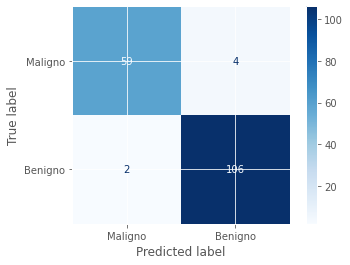

In [149]:

classifier = RandomForestClassifier()

results = []
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test) # avaliando o melhor estimador


print("")
print(classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno']))
report = classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno'], output_dict=True)
results.append(('Modelo', report))
plot_confusion_matrix(classifier, X_test, y_test, cmap="Blues", display_labels=['Maligno', 'Benigno'])
plt.show()

### Avaliando as features do modelo quanto a sua importancia

mean radius: 0.02987
mean texture: 0.01569
mean perimeter: 0.05795
mean area: 0.03378
mean smoothness: 0.00933
mean compactness: 0.00962
mean concavity: 0.07202
mean concave points: 0.14329
mean symmetry: 0.00231
mean fractal dimension: 0.00496
radius error: 0.02104
texture error: 0.00576
perimeter error: 0.01042
area error: 0.02637
smoothness error: 0.00614
compactness error: 0.00437
concavity error: 0.00856
concave points error: 0.00897
symmetry error: 0.00372
fractal dimension error: 0.00598
worst radius: 0.11026
worst texture: 0.02881
worst perimeter: 0.09704
worst area: 0.05737
worst smoothness: 0.00696
worst compactness: 0.01479
worst concavity: 0.05505
worst concave points: 0.12505
worst symmetry: 0.01766
worst fractal dimension: 0.00684


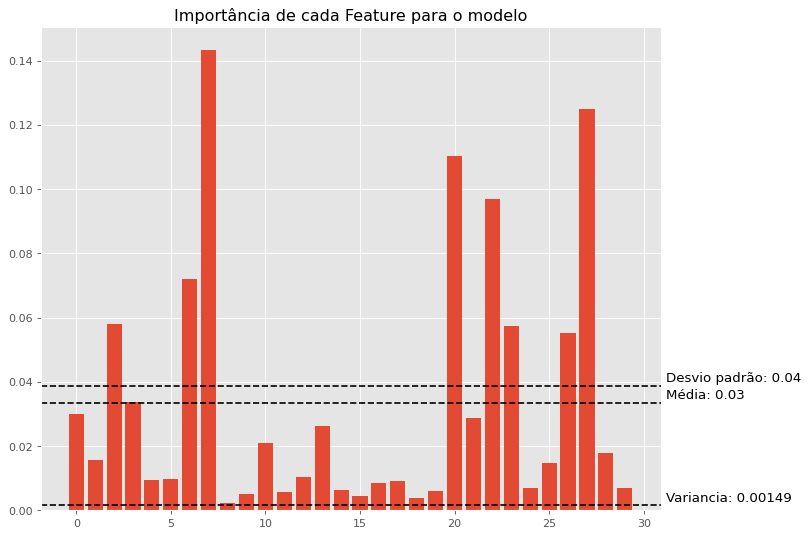

In [150]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

def avaliar_features(melhor_modelo):
    model = melhor_modelo[1]
    model.fit(X_train, y_train)
    importance = model.feature_importances_
    colunas = data.feature_names
    values = []
    # summarize feature importance
    for i,v in enumerate(importance):
        print('%s: %.5f' % (colunas[i],v))
        values.append(v)

    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    std_var = np.std(values)
    media = np.mean(values)
    variancia = np.var(values)
    
    plt.axhline(y= media, linestyle="--", color='k')
    plt.annotate('%s: %.2f' % ('Média',media), xy=(30, media), xycoords='data', xytext=(20, 4), textcoords='offset points', fontsize=12, color='k')
    
    plt.axhline(y= std_var, linestyle="--", color='k')
    plt.annotate('%s: %.2f' % ('Desvio padrão',std_var), xy=(30, std_var), xycoords='data', xytext=(20, 4), textcoords='offset points', fontsize=12, color='k')
   
    plt.axhline(y= variancia, linestyle="--", color='k')
    plt.annotate('%s: %.5f' % ('Variancia',variancia), xy=(30, variancia), xycoords='data', xytext=(20, 4), textcoords='offset points', fontsize=12, color='k')
    plt.title("Importância de cada Feature para o modelo")
    plt.show()

avaliar_features(melhor_modelo)

## Aplicando os algoritmos de redução de dimensões para comparar os resultados

Com base no gráfico, pecebemos que cada uma das features possui um grau diferente de relevancia para o algoritmo. Avaliar a possibilidade de diminuir a quantidade de features economizaria tempo computacional considerável.

### PCA - Principal Component Analysis

              precision    recall  f1-score   support

     Maligno       0.93      0.94      0.93        80
     Benigno       0.97      0.96      0.96       148

    accuracy                           0.95       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.95      0.95      0.95       228



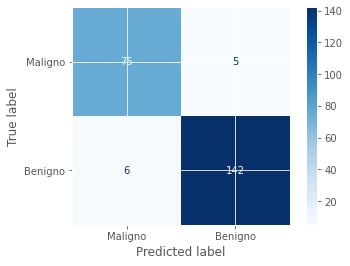

In [151]:
#Aplicar a redução de dimensão em X e rodar o processo novamente com os melhores parametros
from sklearn.decomposition import PCA as sklearnPCA

#escalando dados
minmax_scaler = MinMaxScaler()
X_rescaled  = minmax_scaler.fit_transform(X)
pct_components = 0.95

pca = sklearnPCA(n_components=pct_components)
X_pca = pca.fit_transform(X_rescaled)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.4, random_state=random_state)

#Aplicar o novo X no modelo já treinado
model = classifier.fit(X_train_pca, y_train_pca)
y_pred_pca = model.predict(X_test_pca) # avaliando o melhor estimador

report = classification_report(y_test_pca, y_pred_pca, target_names=['Maligno', 'Benigno'], output_dict=True)
results.append(('PCA', report))
print(classification_report(y_test_pca, y_pred_pca, target_names=['Maligno', 'Benigno']))
plot_confusion_matrix(classifier, X_test_pca, y_test_pca, cmap="Blues", display_labels=['Maligno', 'Benigno'])
plt.show()

### Exibindo o gráfico de componentes necessários com base em uma variancia de 0.95%
Formato de dados antes e depois do PCA

In [152]:
print('Antes: ', X_rescaled.shape)
print('Depois:', X_pca.shape)

Antes:  (569, 30)
Depois: (569, 10)


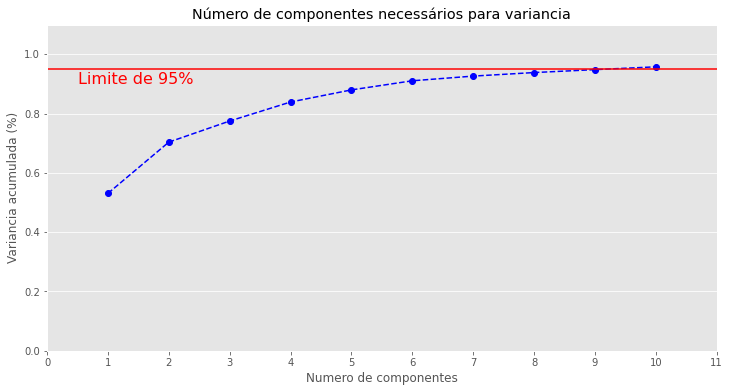

In [153]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, X_pca.shape[1]+1, step=1)
yi = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.xlabel('Numero de componentes')
plt.xticks(np.arange(0, X_pca.shape[1]+2, step=1)) #mudando a escala do eixo só pra ficar mais bacana
plt.ylabel('Variancia acumulada (%)')
plt.title('Número de componentes necessários para variancia')

plt.axhline(y=pct_components, color='r', linestyle='-')
plt.text(0.5, 0.90, 'Limite de 95%', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### SVD - Single Value Decomposition

In [154]:
#Aplicar a redução de dimensão em X e rodar o processo novamente com os melhores parametros
from sklearn.decomposition import TruncatedSVD as sklearnSVD

# Create a function Calculating Number Of Components Required To Pass Threshold
def select_n_components(var_ratio, goal_var):
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

#escalando dados
standard_scaler = StandardScaler()
X_rescaled  = standard_scaler.fit_transform(X)

# Make sparse matrix
X_sparse = csr_matrix(X_rescaled)

# Create and run an TSVD with one less than number of features
tsvd = sklearnSVD(n_components=X_sparse.shape[1]-1)
X_tsvd = tsvd.fit(X)

# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_

componentes = select_n_components(tsvd_var_ratios, pct_components*100)
print(componentes)

29


### Avaliando a quantidade de componentes
pelo gráfico será considerado o uso de 7 componentes

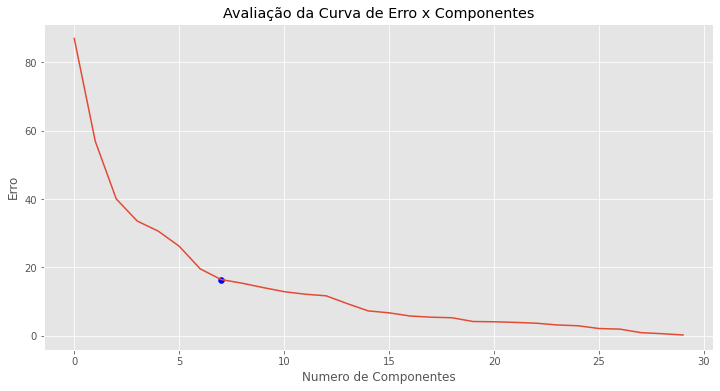

In [155]:
U, S, V = np.linalg.svd(X_rescaled)
k = 7
df = pd.DataFrame({'x_values': list(range(len(S))), 'y_values': S })
plt.rcParams["figure.figsize"] = (12,6)
plt.plot('x_values', 'y_values', data=df)
plt.scatter(k, S[k], color='blue')
plt.title("Avaliação da Curva de Erro x Componentes")
plt.xlabel("Numero de Componentes")
plt.ylabel("Erro")
plt.show()

              precision    recall  f1-score   support

     Maligno       0.94      0.95      0.94        80
     Benigno       0.97      0.97      0.97       148

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228



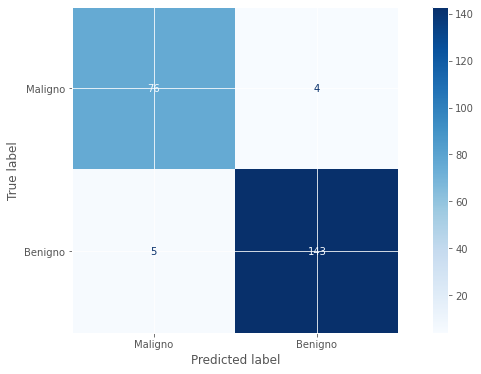

In [156]:
svd = sklearnSVD(n_components=7)
X_svd = svd.fit_transform(X_rescaled)

X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd, y, test_size=0.4, random_state=random_state)

#Aplicar o novo X no modelo já treinado
model = classifier.fit(X_train_svd, y_train_svd)
y_pred_svd = model.predict(X_test_svd) # avaliando o melhor estimador

report = classification_report(y_test_svd, y_pred_svd, target_names=['Maligno', 'Benigno'], output_dict=True)
results.append(('SVD', report))
print(classification_report(y_test_svd, y_pred_svd, target_names=['Maligno', 'Benigno']))
plot_confusion_matrix(classifier, X_test_svd, y_test_svd, cmap="Blues", display_labels=['Maligno', 'Benigno'])
plt.show()

### NMF - Non-negative Matrix Factorization

In [157]:
from sklearn.decomposition import NMF as sklearnNMF
pca = sklearnPCA(n_components=n_dimensions)
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.4, random_state=random_state)

#Aplicar o novo X no modelo já treinado
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test) # avaliando o melhor estimador
classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno'])
report = classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno'], output_dict=True)
results.append(('NMF', report))
plot_confusion_matrix(classifier, X_test, y_test, cmap="Blues")

NameError: name 'n_dimensions' is not defined

### Autoencoder

In [ ]:
## Import do keras
#from keras.layers import Input, Dense
#from keras.models import Model, Sequential
#from keras import regularizers


results[2][1]


### Comparando os resultados

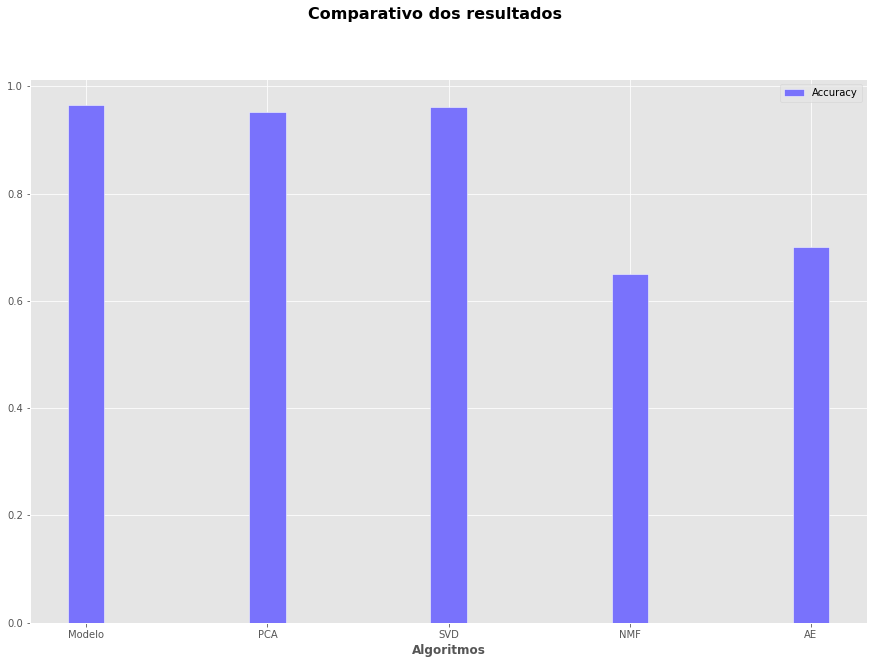

In [160]:
import numpy as np
import matplotlib.pyplot as plt

#report
#macro_precision =  results[0]['macro avg']['precision'] 
#macro_recall = report['macro avg']['recall']    
#macro_f1 = report['macro avg']['f1-score']
#accuracy = report['accuracy']

import numpy as np
import matplotlib.pyplot as plt

barWidth = 0.20

# data to plot
acc = [results[0][1]['accuracy'], results[1][1]['accuracy'], results[2][1]['accuracy'], 0.65, 0.7]
#f1 = [85, 62, 54, 20, 40]
#precision = [85, 62, 54, 20, 30]
#recall = [85, 62, 54, 20, 30]


# Set position of bar on X axis
r1 = np.arange(len(acc))
#r2 = [x + barWidth for x in r1]
#r3 = [x + barWidth for x in r2]
#r4 = [x + barWidth for x in r3]

fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparativo dos resultados', fontsize=16, fontweight='bold')

#make the plot
plt.bar(r1, acc, color='#7972fc', width=barWidth, edgecolor='white', label='Accuracy')
#plt.bar(r2, f1, color='#fc3a51', width=barWidth, edgecolor='white', label='F1')
#plt.bar(r3, precision, color='y', width=barWidth, edgecolor='white', label='Precision')
#plt.bar(r4, recall, color='#4aba50', width=barWidth, edgecolor='white', label='Recall')

# Add xticks on the middle of the group bars
plt.xlabel('Algoritmos', fontweight='bold')
plt.xticks([r  for r in range(len(acc))], ['Modelo', 'PCA', 'SVD', 'NMF', 'AE'])

for x,y in zip(xs,ys):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
 
# Create legend & Show graphicacc
plt.legend()
plt.show()